# Line Plots

The line plot is a fairly common plot type that is used to plot the trend of one numeric variable against values of a second variable. In contrast to a scatterplot, where all data points are plotted, in a line plot, only **one point is plotted for every unique x-value** or bin of x-values (like a histogram). If there are **multiple observations** in an x-bin, then the y-value of the point plotted in the line plot will be **a summary statistic** (like mean or median) of the data in the bin. The plotted points are connected with a line that emphasizes the sequential or connected nature of the x-values.

If the x-variable represents time, then a line plot of the data is frequently known as a time series plot. Often, we have only one observation per time period, like in stock or currency charts. While there is a seaborn function **tsplot** that is intended to be used with time series data, it is fairly specialized and (as of this writing's seaborn 0.8) is slated for major changes.

In [69]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df=pd.read_csv('../Code/fuel-econ.csv')
df.head()

,id,make,model,year,VClass,drive,trans,fuelType,cylinders,displ,pv2,pv4,city,UCity,highway,UHighway,comb,co2,feScore,ghgScore
0,32204,Nissan,GT-R,2013,Subcompact Cars,All-Wheel Drive,Automatic (AM6),Premium Gasoline,6,3.8,79,0,16.4596,20.2988,22.5568,30.1798,18.7389,471,4,4
1,32205,Volkswagen,CC,2013,Compact Cars,Front-Wheel Drive,Automatic (AM-S6),Premium Gasoline,4,2.0,94,0,21.8706,26.9770,31.0367,42.4936,25.2227,349,6,6
2,32206,Volkswagen,CC,2013,Compact Cars,Front-Wheel Drive,Automatic (S6),Premium Gasoline,6,3.6,94,0,17.4935,21.2000,26.5716,35.1000,20.6716,429,5,5
3,32207,Volkswagen,CC 4motion,2013,Compact Cars,All-Wheel Drive,Automatic (S6),Premium Gasoline,6,3.6,94,0,16.9415,20.5000,25.2190,33.5000,19.8774,446,5,5
4,32208,Chevrolet,Malibu eAssist,2013,Midsize Cars,Front-Wheel Drive,Automatic (S6),Regular Gasoline,4,2.4,0,95,24.7726,31.9796,35.5340,51.8816,28.6813,310,8,8


we will make use of **Matplotlib's errorbar function**, performing some processing on the data in order to get it into its necessary form.

<Container object of 3 artists>

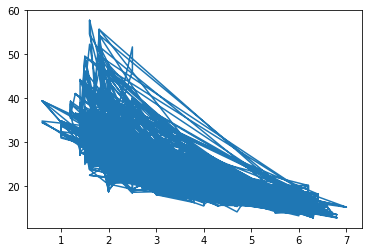

In [70]:
plt.errorbar(data=df, x='displ', y='comb')

If we just blindly stick a dataframe into the function without considering its structure, we might end up with a mess like the above. The function just plots all the data points as a line, connecting values from the first row of the dataframe to the last row. In order to create the line plot as intended, we need to do additional work to summarize the data.

<Container object of 3 artists>

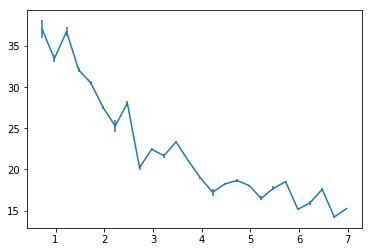

In [87]:
# set bin edges, compute centers
bin_size=.25
bin_edges=np.arange(df.displ.min(),df.displ.max()+bin_size,bin_size)
bin_centers=(bin_edges+bin_size/2)[:-1]

data_xbins =pd.cut(df.displ, bin_edges, labels=False, include_lowest=True, right=False)
y_mean=df.comb.groupby(data_xbins).mean()
y_std=df.comb.groupby(data_xbins).sem()

plt.errorbar(x=bin_centers , y=y_mean, yerr=y_std)

Since the x-variable ('displ') is continuous, we first set a number of bins into which the data will be grouped. In addition to the usual edges, the center of each bin is also computed for later plotting. For the points in each bin, we compute **the mean and standard error of the mean**.

An interesting part of the above summarization of the data is that the uncertainty in the mean generally decreases with increasing x-values. But for the largest two points, there are no error bars. Looking at the default **errorbar plot** we can see this is due to there only being one point in each of the last two bins.

# Alternate Variations

Instead of computing summary statistics on fixed bins, you can also make computations on a rolling window through use of **pandas' rolling** method. Since the rolling window will make computations on **sequential rows** of the dataframe, we should use **sort_values** to put the x-values in **ascending order** first.

<Container object of 3 artists>

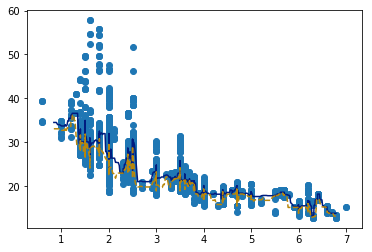

In [73]:
# compute statistics in a rolling window
df_window = df.sort_values('displ').rolling(15)
x_winmean = df_window.mean() ['displ']
y_median  = df_window.median() ['comb']
y_q1 = df_window.quantile(.25) ['comb']
y_q3 = df_window.quantile(.75) ['comb']

# plot the summarized data
base_color=sb.color_palette()[0]


plt.scatter(data=df, x='displ', y='comb')
plt.errorbar(x=x_winmean, y=y_median, c=sb.color_palette('dark')[0])
plt.errorbar(x=x_winmean, y=y_q1, c=sb.color_palette('dark')[4], linestyle='--')
#plt.errorbar(x=x_winmean, y=y_q3, c=sb.color_palette('dark')[2], linestyle='--')

Note that we're also not limited to just one line when plotting. When multiple Matplotlib functions are called one after the other, all of them will be plotted on the same axes. Instead of plotting the mean and error bars, we will plot the three central quartiles, laid on top of the scatterplot.

Another bivariate application of line plots is to plot the distribution of a numeric variable for different levels of a categorical variable. This is another alternative to using violin plots, box plots, and faceted histograms. With the line plot, one line is plotted for each category level, like overlapping the histograms on top of one another. This can be accomplished through multiple **errorbar** calls using the methods above, or by performing multiple **hist calls**, setting the **"histtype = step"** parameter so that the bars are depicted as unfilled lines.



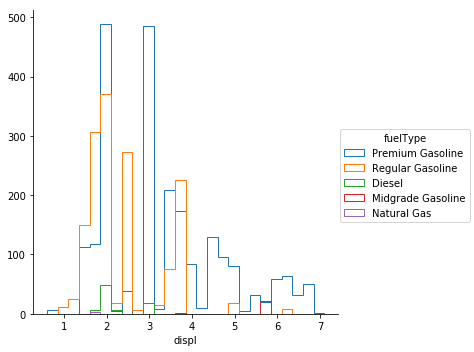

In [74]:
bin_edges=np.arange(df.displ.min(),df.displ.max()+.25,.25)
g=sb.FacetGrid(data=df, hue='fuelType', size=5)
g.map(plt.hist,'displ' ,bins=bin_edges, histtype='step')
g.add_legend()

Note that I'm performing the multiple hist calls through the use of FacetGrid, setting the categorical variable on the **"hue" parameter** rather than the "col" parameter. I've added an add_legend method call so that we can identify which level is associated with each curve.

Unfortunately, the "Diesel" curve seems to be pretty lost behind the other four curves since the relatively low number of counts is causing a lot of overlap. Perhaps connecting the centers of the bars with a line, like what was seen in the first errorbar example, would be better.

Functions you provide to the map method of FacetGrid objects do not need to be built-ins. Below, I've written a function to perform the summarization operations seen above to plot an errorbar line for each level of the categorical variable, then fed that function (freq_poly) to map.

In [79]:
def freq_poly(x, bins = 10, **kwargs):
    """ Custom frequency polygon / line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    counts = x.groupby(data_bins).count()

    # create plot
    plt.errorbar(x = bin_centers, y = counts, **kwargs)


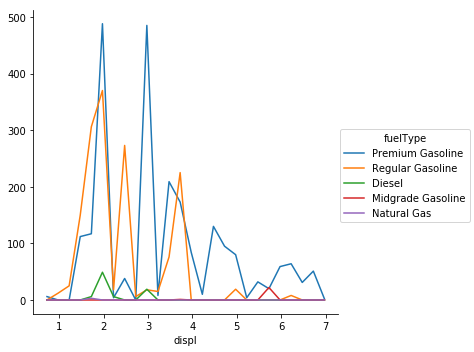

In [90]:
bin_edges=np.arange(df.displ.min(),df.displ.max()+.25,.25)
g = sb.FacetGrid(data = df, hue = 'fuelType', size = 5)
g.map(freq_poly, "displ", bins = bin_edges)
g.add_legend()

**kwargs is used to allow additional keyword arguments to be set for the errorbar function.